In [1]:
# %load LuiseUtil.py
import os
import shutil
import math
from ete3 import Tree
from Bio import Phylo
import matplotlib
import matplotlib.pyplot as plt
from codecs import decode
import struct

from Bio import Phylo, AlignIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio.AlignIO.PhylipIO import PhylipWriter

import numpy as np
from scipy import stats


raxml_ng_path = './../../tools/raxml-ng/build/bin/raxml-ng'
standard_raxml_path = './../../tools/standard-RAxML-master/raxmlHPC-AVX '

tree_dir = 'data/trees/'
alignment_dir = 'data/language_alignments/'
sitelh_dir = 'data/siteLH/'
drawings_dir = 'output/drawings/'
weight_calibration_dir = 'data/weight_calibration/'
site_congruence_dir = 'data/site_congruence/'
lh_dir = 'data/lh/'
indices_dir = 'data/indices/'
deltas_dir = "data/trait_association/delta_statistics/"


#tree_space_name = 'space.trees'
geo_tree_name = "geo_duration.tree"
cognate_tree_name = "cognate_ie_compatible.tree"
cognate_ml_tree_name = "cognate_ml.tree"

morpho_alignment_name = "morpho.phy"



def read_trees_from_ete(tree_set_names):
    trees = []
    for tree_set in tree_set_names:
        l_file = open(tree_dir + tree_set, 'r')
        lines = l_file.readlines()
        for line in lines:
            trees.append(Tree(line))
    return trees

#def read_tree_space_ete():
#    return read_trees_from_ete([tree_space_name])


def eliminate_topological_duplicates_ete(tree_set_names, out_file_name):
    unique_list = []
    tree_set_ete = read_trees_from_ete(tree_set_names)
    i = 0
    for t1 in tree_set_ete:
        unique = True
        for t2 in unique_list:
            rf = rf_distance_ete(t1, t2)
            if rf == 0:
                unique = False
                break
        if unique:
            unique_list.append(t1)
        i = i + 1
    file_name = tree_dir + out_file_name
    with open(file_name, 'w+') as tree_file:
        for tree in unique_list:
            tree_file.write(tree.write()+"\n")
    print(file_name + " created")

def set_neg_branches_zero_ete(tree):
    for node in tree.traverse("postorder"):
        if node.dist < 0:
            node.dist = 0
    return tree

def set_neg_branches_zero(tree_set_name):
    trees = read_trees_from_ete([tree_set_name])
    for tree in trees:
        tree = set_neg_branches_zero_ete(tree)
    file_name = tree_dir + tree_set_name
    with open(file_name, 'w+') as tree_file:
        for tree in trees:
            tree_file.write(tree.write()+"\n")



#def create_tree_space_from(tree_set_names):
#    tree_space_ete = read_trees_from_ete(tree_set_names)
#    file_name = tree_dir + tree_space_name
#    with open(file_name, 'w+') as tree_file:
#        for tree in tree_space_ete:
#            tree_file.write(tree.write()+"\n")
#    print(str(len(tree_space_ete)) + " trees written to " + file_name)

def read_geo_tree_ete():
    return Tree(tree_dir + geo_tree_name)

def read_cognate_tree_ete():
    return Tree(tree_dir + cognate_tree_name)

def rf_distance_ete(t1, t2):
    rf, max_rf, common_leaves, parts_t1, parts_t2,discard_t1, discart_t2 = t1.robinson_foulds(t2, unrooted_trees = True)
    if max_rf == 0:
        print("?!")
        return 0
    return rf/max_rf

def rf_distances_ete(ref_tree, tree_set):
    distances = []
    for tree in tree_set:
        distances.append(rf_distance_ete(ref_tree, tree))
    return distances


def calculate_rf_distances_raxml(ref_tree_name, tree_set_names):
    shutil.rmtree("temp/", ignore_errors=True)
    os.mkdir("temp/")
    dir_string = tree_dir + ref_tree_name
    for tree_set in tree_set_names:
        dir_string = dir_string + tree_dir + tree_set
    os.system("cat " + dir_string + " > temp/all.trees")
    os.system(raxml_ng_path + " --rfdist --tree temp/all.trees --prefix temp/foo > temp/bar.txt")
    l_file = open('temp/foo.raxml.rfDistances', 'r')
    lines = l_file.readlines()
    i = 0
    line = lines[i].split("\t")
    distances = []
    while(line[0] == '0'):
        distances.append(float(line[3]))
        i+=1
        line = lines[i].split("\t")
    shutil.rmtree("temp/", ignore_errors=True)
    return distances


def evaluate_lh_raxml(tree_name, alignment_name, optimize = True):
    optimize_string = ""
    if not optimize:
        optimize_string = " --opt-branches off "
    os.system(raxml_ng_path + ' --evaluate --msa ' + alignment_dir + alignment_name +
            ' --threads 2 --model BIN+G --tree '  + tree_dir + tree_name +  ' --prefix foo --nofiles' +
              optimize_string + '> out.txt')
    l_file = open('out.txt', 'r')
    lines = l_file.readlines()
    lh = 0
    for line in lines:
        if(line.startswith('Final LogLikelihood:')):
            lh = float(line.split(" ")[2].strip())
    os.remove("out.txt")
    return lh







def calculate_site_lh_raxml_ete(tree_ete, alignment_name, optimize= True):
    shutil.rmtree("temp/", ignore_errors=True)
    os.mkdir("temp/")
    tree_ete.write(outfile="temp/foo.tree")
    optimize_string = ""
    if not optimize:
        optimize_string = " --opt-branches off "
    os.system(raxml_ng_path + ' --sitelh --msa ' + alignment_dir + alignment_name +
            ' --threads 2 --model BIN+G --tree temp/foo.tree --prefix temp/foo ' +
              optimize_string + '> temp/bar.txt')
    l_file = open('temp/foo.raxml.log', 'r')
    lines = l_file.readlines()
    lh = 0
    for line in lines:
        if(line.startswith('Final LogLikelihood:')):
            lh = float(line.split(" ")[2].strip())
    with open('temp/foo.raxml.siteLH' , 'r') as file:
        data = (file.read().replace('\n', '')).split(" ")
    #siteLH = [float(data[i]) for i in range(5, len(data))]
    siteLH = [data[i] for i in range(5, len(data))]
    shutil.rmtree("temp/", ignore_errors=True)
    return [lh, siteLH]




def print_tree_with_phylo(tree_name, save = False):
    tree = Phylo.read(tree_dir + tree_name, "newick")
    tree.ladderize()
    fig = plt.figure(figsize=(10, 10), dpi=100)
    axes = fig.add_subplot(1, 1, 1)
    axes.set_title(tree_name)
    Phylo.draw(tree, axes=axes, do_show=False)
    if save:
        plt.savefig(drawings_dir + tree_name + '.png', dpi=fig.dpi)


def fix_beast_output(tree_set_name):
    beast_file = open(tree_dir + tree_set_name, 'r')
    lines = beast_file.readlines()
    i = 0
    while not lines[i].startswith("\tTranslate"):
        i = i+1
    translate = []
    while not lines[i].startswith(";"):
        if lines[i].endswith(",\n"):
            translate.append(lines[i].split(" ")[-1][:-2])
        else:
            translate.append(lines[i].split(" ")[-1][:-1])
        i=i+1
    i = i+1
    with open(tree_dir + rm_end(tree_set_name) + "_fixed.trees" , 'w+') as fixed_file:
        for j in range(i, len(lines)-1):
            tree = Tree(lines[j].split(" ")[-1])
            for leaf in tree.iter_leaves():
                leaf.name = translate[int(leaf.name)]
            fixed_file.write(tree.write() + "\n")

def rm_end(file_name):
    return '.'.join(file_name.split('.') [:-1])

def lh_file_name(tree_set_name, alignment_name, optimize):
    optimize_string = "_opt-branches="
    if optimize:
        optimize_string = optimize_string + "on"
    else:
        optimize_string = optimize_string + "off"
    return lh_dir + rm_end(alignment_name) + '_' + rm_end(tree_set_name)  + optimize_string + '.lh'

def lh_raw_file_name(tree_set_name, alignment_name, optimize):
    optimize_string = "_opt-branches="
    if optimize:
        optimize_string = optimize_string + "on"
    else:
        optimize_string = optimize_string + "off"
    return lh_dir + rm_end(alignment_name) + '_' + rm_end(tree_set_name)  + optimize_string + '_raw.lh'


def site_lh_file_name(tree_name, alignment_name, optimize):
    optimize_string = "_opt-branches="
    if optimize:
        optimize_string = optimize_string + "on"
    else:
        optimize_string = optimize_string + "off"
    return sitelh_dir + rm_end(alignment_name) + '_' + rm_end(tree_name)  + optimize_string + '.raxml.siteLH'

def site_lh_raw_file_name(tree_name, alignment_name, optimize):
    optimize_string = "_opt-branches="
    if optimize:
        optimize_string = optimize_string + "on"
    else:
        optimize_string = optimize_string + "off"
    return sitelh_dir + rm_end(alignment_name) + '_' + rm_end(tree_name)  + optimize_string + '_raw.raxml.siteLH'

def weight_calibration_file_name(tree_name, alignment_name):
    return weight_calibration_dir + rm_end(alignment_name) + '_' + rm_end(tree_name)  + '.raxml.weightCalibration'

def site_congruence_file_name(tree_name, alignment_name):
    return site_congruence_dir + rm_end(alignment_name) + '_' + rm_end(tree_name)  + '.raxml.siteCongruence'

def optimized_tree_file_name(tree_name, alignment_name):
    return tree_dir + rm_end(tree_name) + '_optimized_' + rm_end(alignment_name)  + '.tree'

def ml_trees_file_name(alignment_name, start_trees = ""):
    if start_trees == "":
        return tree_dir + rm_end(alignment_name) + ".raxml.mlTrees"
    else:
        return tree_dir + rm_end(alignment_name) + "_" + start_trees + ".raxml.mlTrees"

def best_tree_file_name(alignment_name, start_trees = ""):
    if start_trees == "":
        return tree_dir + rm_end(alignment_name) + ".raxml.bestTree"
    else:
        return tree_dir + rm_end(alignment_name) + "_" + start_trees + ".raxml.bestTree"

def deltas_file_name(tree_name, alignment_name):
    return deltas_dir + rm_end(alignment_name) + '_' + rm_end(tree_name)  + '.deltas'


def read_lhs(tree_set_name, alignment_name, optimize):
    lhs = []
    site_lhs = []
    with open(lh_file_name(tree_set_name, alignment_name, optimize) , 'r') as file:
        lines = file.read().split("\n")
    for line in lines[:-1]:
        line_data = line.split("\t")
        lhs.append(float(line_data[0]))
        site_lhs.append([float(el) for el in line_data[1].split(" ")[:-1]])
    return (lhs, site_lhs)

def read_lhs_raw(tree_set_name, alignment_name, optimize):
    lhs = []
    site_lhs = []
    with open(lh_raw_file_name(tree_set_name, alignment_name, optimize) , 'r') as file:
        lines = file.read().split("\n")
    for line in lines[:-1]:
        line_data = line.split("\t")
        lhs.append(float(line_data[0]))
        site_lhs.append([bin_to_float(el) for el in line_data[1].split(" ")[:-1]])
    return (lhs, site_lhs)

def read_site_lh(tree_name, alignment_name, optimize):
    with open(site_lh_file_name(tree_name, alignment_name, optimize) , 'r') as file:
        data = (file.read().replace('\n', '')).split(" ")
    return [float(data[i]) for i in range(5, len(data))]

def read_site_lh_raw(tree_name, alignment_name, optimize):
    with open(site_lh_raw_file_name(tree_name, alignment_name, optimize) , 'r') as file:
        data = (file.read().replace('\n', '')).split(" ")
    return [bin_to_float(data[i]) for i in range(5, len(data))]

def read_weight_calibration(tree_name, alignment_name):
    with open(weight_calibration_file_name(tree_name, alignment_name) , 'r') as file:
        data = file.read().split(" ")
    return [int(data[i]) for i in range(len(data) - 1)]

def read_site_congruence(tree_name, alignment_name):
    with open(site_congruence_file_name(tree_name, alignment_name) , 'r') as file:
        data = file.read().split("\n")
    return [float(data[i].split(" ")[1]) for i in range(len(data) - 1)]

def read_optimized_tree(tree_name, alignment_name):
    return Tree(optimized_tree_file_name(tree_name, alignment_name))

def read_ml_trees(alignment_name, start_trees = ""):
    tree_file = open(ml_trees_file_name(alignment_name, start_trees))
    return [Tree(line[:-1]) for line in tree_file.readlines()]

def read_best_tree(alignment_name, start_trees = ""):
    tree_file = open(best_tree_file_name(alignment_name, start_trees))
    return Tree(tree_file.readlines()[0][:-1])


def read_deltas(alignment_name, tree_name):
    deltas_file = open(deltas_file_name(alignment_name, tree_name))
    return [float(line) for line in deltas_file.readlines()]

def calculate_lhs_raxml(tree_set_name, alignment_name, optimize = False):
    tree_set = read_trees_from_ete([tree_set_name])
    results = [calculate_site_lh_raxml_ete(tree, alignment_name, optimize) for tree in tree_set]
    with open(lh_raw_file_name(tree_set_name, alignment_name, optimize), 'w+') as out_file:
        for result in results:
            out_file.write(str(result[0]))
            out_file.write("\t")
            for site_lh in result[1]:
                #out_file.write(str(site_lh))
                out_file.write(site_lh)
                out_file.write(" ")
            out_file.write("\n")

def calculate_site_lh_raxml(tree_name, alignment_name, optimize= True):
    shutil.rmtree("temp/", ignore_errors=True)
    os.mkdir("temp/")
    optimize_string = ""
    if not optimize:
        optimize_string = " --opt-branches off "
    os.system(raxml_ng_path + ' --sitelh --msa ' + alignment_dir + alignment_name +
            ' --threads 2 --model BIN+G --tree '  + tree_dir + tree_name +  ' --prefix temp/foo ' +
              optimize_string + '> temp/bar.txt')
    l_file = open('temp/foo.raxml.log', 'r')
    lines = l_file.readlines()
    lh = 0
    for line in lines:
        if(line.startswith('Final LogLikelihood:')):
            lh = float(line.split(" ")[2].strip())
    #os.system("cat temp/foo.raxml.siteLH > " + site_lh_file_name(tree_name, alignment_name, optimize))
    os.system("cat temp/foo.raxml.siteLH > " + site_lh_raw_file_name(tree_name, alignment_name, optimize))
    with open('temp/foo.raxml.siteLH' , 'r') as file:
        data = (file.read().replace('\n', '')).split(" ")
    #siteLH = [float(data[i]) for i in range(5, len(data))]
    siteLH = [data[i] for i in range(5, len(data))]
    shutil.rmtree("temp/", ignore_errors=True)
    return [lh, siteLH]

def calculate_weight_calibration_raxml(tree_name, alignment_name):
    os.system(standard_raxml_path + ' -f u -p 12345 -t ' + tree_dir + tree_name +
              ' -m BINGAMMA -s ' + alignment_dir + alignment_name +
              ' -n calibration > bar.txt')
    os.system('cat RAxML_weights.calibration > '
              + weight_calibration_file_name(tree_name, alignment_name))
    os.remove('bar.txt')
    os.remove('RAxML_weights.calibration')
    os.remove('RAxML_info.calibration')

def calculate_site_congruence_raxml(tree_name, alignment_name):
    os.system(standard_raxml_path + ' -f S -t ' + tree_dir + tree_name +
              ' -m BINGAMMA -s ' + alignment_dir + alignment_name +
              ' -n congruence > bar.txt')
    os.system('cat RAxML_SiteSpecificPlacementBias.congruence > '
              + site_congruence_file_name(tree_name, alignment_name))
    os.remove('bar.txt')
    os.remove('RAxML_SiteSpecificPlacementBias.congruence')
    os.remove('RAxML_info.congruence')

def calculate_optimized_tree_raxml(tree_name, alignment_name):
    shutil.rmtree("temp/", ignore_errors=True)
    os.mkdir("temp/")
    os.system(raxml_ng_path + ' --evaluate --msa ' + alignment_dir + alignment_name +
            ' --threads 2 --model BIN+G --tree '  + tree_dir + tree_name +  ' --prefix temp/foo ' + '> out.txt')
    os.system('cat temp/foo.raxml.bestTree > ' + tree_dir + rm_end(tree_name) + "_optimized_" + rm_end(alignment_name) + '.tree')
    shutil.rmtree("temp/", ignore_errors=True)


def calculate_ml_trees_raxml(alignment_name, start_trees = ""):
    shutil.rmtree("temp/", ignore_errors=True)
    os.mkdir("temp/")
    if start_trees == "":
        os.system(raxml_ng_path + ' --msa ' + alignment_dir + alignment_name +
            ' --threads 2 --seed 2 --model BIN+G --prefix temp/foo > temp/bar.txt')
    else:
        os.system(raxml_ng_path + ' --msa ' + alignment_dir + alignment_name +
            ' --tree ' + start_trees +
            ' --threads 2 --seed 2 --model BIN+G --prefix temp/foo > temp/bar.txt')
    os.system('cat temp/foo.raxml.mlTrees > ' + ml_trees_file_name(alignment_name, start_trees))
    os.system('cat temp/foo.raxml.bestTree > ' + best_tree_file_name(alignment_name, start_trees))



def get_site_lh(tree_name, alignment_name, optimize):
    if not os.path.isfile(site_lh_file_name(tree_name, alignment_name, optimize)):
        print("Currently not possible, use site_lh_raw")
        #calculate_site_lh_raxml(tree_name, alignment_name, optimize)
    return read_site_lh(tree_name, alignment_name, optimize)

def get_site_lh_raw(tree_name, alignment_name, optimize):
    if not os.path.isfile(site_lh_raw_file_name(tree_name, alignment_name, optimize)):
        calculate_site_lh_raxml(tree_name, alignment_name, optimize)
    return read_site_lh_raw(tree_name, alignment_name, optimize)


def get_weight_calibration(tree_name, alignment_name):
    if not os.path.isfile(weight_calibration_file_name(tree_name, alignment_name)):
        calculate_weight_calibration_raxml(tree_name, alignment_name)
    return read_weight_calibration(tree_name, alignment_name)

def get_site_congruence(tree_name, alignment_name):
    if not os.path.isfile(site_congruence_file_name(tree_name, alignment_name)):
        calculate_site_congruence_raxml(tree_name, alignment_name)
    return read_site_congruence(tree_name, alignment_name)

def get_optimized_tree(tree_name, alignment_name):
    if not os.path.isfile(optimized_tree_file_name(tree_name, alignment_name)):
        calculate_optimized_tree_raxml(tree_name, alignment_name)
    return read_optimized_tree(tree_name, alignment_name)

def get_double_optimized_tree(tree_name, alignment_name):
    if not os.path.isfile(optimized_tree_file_name(tree_name, alignment_name)):
        calculate_optimized_tree_raxml(tree_name, alignment_name)
    optimized_tree_name = optimized_tree_file_name(tree_name, alignment_name).split('/')[-1]
    if not os.path.isfile(optimized_tree_file_name(optimized_tree_name, alignment_name)):
        calculate_optimized_tree_raxml(optimized_tree_name, alignment_name)
    return read_optimized_tree(optimized_tree_name, alignment_name)


def get_optimized_tree(tree_name, alignment_name):
    if not os.path.isfile(optimized_tree_file_name(tree_name, alignment_name)):
        calculate_optimized_tree_raxml(tree_name, alignment_name)
    return read_optimized_tree(tree_name, alignment_name)


def get_lhs(tree_set_name, alignment_name, optimize):
    if not os.path.isfile(lh_file_name(tree_set_name, alignment_name, optimize)):
        #calculate_lhs_raxml(tree_set_name, alignment_name, optimize)
        print("Currently not possible, use lhs_raw")
    return read_lhs(tree_set_name, alignment_name, optimize)

def get_lhs_raw(tree_set_name, alignment_name, optimize):
    if not os.path.isfile(lh_raw_file_name(tree_set_name, alignment_name, optimize)):
        calculate_lhs_raxml(tree_set_name, alignment_name, optimize)
    return read_lhs_raw(tree_set_name, alignment_name, optimize)


def get_ml_trees(alignment_name, start_trees = ""):
    if not os.path.isfile(ml_trees_file_name(alignment_name, start_trees)):
        calculate_ml_trees_raxml(alignment_name, start_trees)
    return read_ml_trees(alignment_name, start_trees)

def get_best_tree(alignment_name, start_trees = ""):
    if not os.path.isfile(best_tree_file_name(alignment_name, start_trees)):
        calculate_ml_trees_raxml(alignment_name, start_trees)
    return read_best_tree(alignment_name, start_trees)


def get_deltas(tree_name, alignment_name):
    if not os.path.isfile(deltas_file_name(alignment_name, tree_name)):
        print("Deltas must be calculated in R!")
    return read_deltas(alignment_name, tree_name)

def average_branch_length(tree_set):
    avg = 0
    cnt = 0
    for tree in tree_set:
        for node in tree.traverse():
            avg = avg + node.dist
            cnt = cnt + 1
    avg = avg / cnt
    return avg



def interval_branch_length(tree_set):
    lower = 1
    upper = 0
    for tree in tree_set:
        for node in tree.traverse():
            lower = min(lower, node.dist)
            upper = max(upper, node.dist)
    return (lower, upper)



def variance_branch_length(tree_set):
    avg = average_branch_length(tree_set)
    var = 0
    cnt = 0
    for tree in tree_set:
        for node in tree.traverse():
            diff = node.dist - avg
            var = var + (diff * diff)
            cnt = cnt + 1
    return var / cnt


def bin_to_float(b):
    return struct.unpack('>d', decode('%%0%dx' % (8 << 1) % int(b, 2), 'hex')[-8:])[0]


def rf_dist_matrix(tree_dict):
    for i, name1 in enumerate(tree_dict):
        for j, name2 in enumerate(tree_dict):
            if name2 <= name1:
                continue
            rf_str = str(rf_distance_ete(tree_dict[name1], tree_dict[name2]))
            print("RF distance of " + name1 + " to " + name2 + ": " + rf_str)





kit_green = "#009682"
kit_orange = "#DF9B1B"
kit_blue = "#0A64AA"
kit_maigreen = "#8CB63C"
kit_yellow = "#FCE500"
kit_red = "#A22223"
kit_lila = "#A3107C"
kit_cyan = "#23A1E0"

names_dict = {
    "cognate_ie_compatible.tree" : "$T_C$",
    "geo_duration.tree" : "$T_G$",

    "morpho.phy" : "$A$",
    "morpho_filtered_indsToUse.phy" : "$\hat{A}$",
    "cognate.phy" : "$A_C$",

    "significant_all_interim.trees" : "$\mathcal{T}_{\t{im}}(\hat{A})$",
    "all_interim.trees" : "$\mathcal{T}_{\t{im}}(A)$",
    "filtered_all_interim.trees" : "$\mathcal{T}_{\t{im}}(A_f)$",

    "significant_all_start.trees" : "$\mathcal{T}_{\t{st}}(\hat{A})$",
    "all_start.trees" : "$\mathcal{T}_{\t{st}}(A)$",
    "filtered_all_start.trees" : "$\mathcal{T}_{\t{st}}(A_f)$",

    "morpho_filtered_nj_final.phy": "$A_{NJ}$",
    "morpho_filtered_pars_final.phy": "$A_{Pars}$",
    "morpho_filtered_ml_final.phy": "$A_{ML}$"
}



def quartet_distance(tree_name1, tree_name2):
    tree_name1 = os.path.join(tree_dir, tree_name1)
    tree_name2 = os.path.join(tree_dir, tree_name2)
    os.system("./../../tools/qdist/qdist " + tree_name1 + " " + tree_name2 + " >out.txt")
    qdist = float(open("out.txt").readlines()[1].split("\t")[-1])
    os.remove("out.txt")
    return qdist

def quartet_distances(ref_tree_name, tree_set):
    ref_tree_path  = os.path.join(tree_dir, ref_tree_name)
    qdists = []
    for tree in tree_set:
        open("temp.tree", 'w+').write(tree.write())
        os.system("./../../tools/qdist/qdist temp.tree " +  ref_tree_path + " >out.txt")
        qdists.append(float(open("out.txt").readlines()[1].split("\t")[-1]))
    os.remove("out.txt")
    os.remove("temp.tree")
    return qdists

def average_rf_distance_in_tree_set(tree_set_name):
    trees = read_trees_from_ete([tree_set_name])
    distances = []
    if (len(trees) < 2):
        return 0
    for (i, tree1) in enumerate(trees):
        for j in range(i+1, len(trees)):
            tree2 = trees[j]
            distances.append(rf_distance_ete(tree1, tree2))
    return sum(distances) / len(distances)

def num_trees(tree_set_name):
    return len(open(tree_dir + tree_set_name).readlines())

def average_rf_distance_to_ref_tree(tree_set_name, tree_name):
    tree = Tree(tree_dir + tree_name)
    trees = read_trees_from_ete([tree_set_name])
    dists = rf_distances_ete(tree, trees)
    return sum(dists)/len(dists)


def p_value(a1, a2):
    return stats.ttest_ind(a1, a2)[1]

def pearson_cc(a1, a2):
    return np.corrcoef(a1, a2)[0][1]








In [2]:
# basics

import re
max_rf = 86

def get_index(file):
    block = file.split('/')[-1].split('.')[0].split('_')[-1]
    match = re.match(r"([a-z]+)([0-9]+)", block, re.I)
    if match:
        idx = int(match.groups()[1])
        return idx
    return None

def get_results(alg):
    d = 'output/project_pavlos/' + alg + '_results'
    old_cwd = os.getcwd()
    d = os.path.join(old_cwd, d)
    os.chdir(d)
    files = filter(os.path.isfile, os.listdir(d))
    files = [os.path.join(d, f) for f in files] # add path to each file
    full_alignment_length = 219

    bit_matrix = {}
    indices_matrix = {}
    rfs = {}

    for file in files:
        idx = get_index(file)
        if file.endswith(".csv"):
            indices_file = open(file)
            indices = [int(line[:-1]) for line in indices_file.readlines()]
            indices_matrix[idx] = indices
            bits = [0 for i in range(full_alignment_length)]
            for i in indices:
                bits[i-1] = 1
            bit_matrix[idx] = bits
        if "current_accuracy_step" in file.split("/")[-1]:
            if idx == 1:
                continue
            rf_file = open(file)
            line = rf_file.readlines()[0][:-1]
            if len(line.split('e')) == 2:
                rf = int(float(line))
            else:
                rf = int(line)
            rfs[idx] = rf
    os.chdir(old_cwd)
    return indices_matrix, rfs, bit_matrix


def first_opt_idx(rfs):
    max_idx = max(rfs.keys())
    min_idx = max_idx
    for (idx, rfd) in rfs.items():
        if rfd == rfs[max_idx] and idx < min_idx:
            min_idx = idx
    return min_idx

In [3]:
# file creation

#Problem: Data in Pavlos' Algorithm uses "PtgE" (see cognate_ie.tree)
# we use "Ptg-E" (see cognate_ie_compatible.tree)
def fix_ptge(file_path):
    with open(file_path) as f:
        newText=f.read().replace('PtgE', 'Ptg-E')

    with open(file_path, "w") as f:
        f.write(newText)


def write_tree_set(alg, start_idx, end_idx, out_file_name):
    trees = []
    i = start_idx
    while i <= end_idx:
        if alg == "nj":
            fname = "output/project_pavlos/" + alg + "_results/current_opt_tree_large_step" + str(i) + ".nwk"
            trees.append(Tree(fname))
        else:
            fname = "output/project_pavlos/" + alg + "_results/" + alg + "_current_opt_tree_large_step" + str(i) + ".nwk"
            trees.append(Tree(fname))
        if i == 1: #special case for first output file because of indexing in R
            i = 10000
        else:
            i += 10000
    file_name = tree_dir + out_file_name
    with open(file_name, 'w+') as tree_file:
        for tree in trees:
            tree_file.write(tree.write()+"\n")
    fix_ptge(file_name)
    set_neg_branches_zero(out_file_name)
            
 
            
            
def convert_pavlos_indices(pavlos_indices, file_name):
    inds_to_use = [int(l) for l in open(indices_dir + "indsToUse_R").readlines()]
    with open(indices_dir + file_name, "w+") as inds_file:
        for ind in pavlos_indices:
            true_ind = inds_to_use[ind-1]-1
            inds_file.write(str(true_ind) + "\n")
            
def filter_align(alignment_name, indices_file_name, fix = True):
    filtered_alignment_name = alignment_name.split(".")[0] + "_filtered_" + indices_file_name + ".phy"
    align = AlignIO.read(alignment_dir + alignment_name, "phylip")
    if fix:
    #    # fixing process only required if AlignIO has problems with format
        records = []
        for i in range(0, len(align)):
            full_sequence = align[i].id.split(" ")[-1] + align[i].seq
            records.append(SeqRecord(Seq(full_sequence), id=align[i].id.split(" ")[0]))
        align = MultipleSeqAlignment(records, annotations={}, column_annotations={})
    indices_file = open(indices_dir + indices_file_name)
    indices = [int(line[:-1]) for line in indices_file.readlines()]
    idx = indices[0]
    filtered_align = align[:, idx:idx+1]
    for i in range(1, len(indices)):
        idx = indices[i]
        filtered_align = filtered_align + align[:, idx:idx+1]

    with open(alignment_dir + filtered_alignment_name,"w+") as f:
        writer = PhylipWriter(f)
        writer.write_alignment(filtered_align)
        
        
def create_files(alg):
    indices_matrix, rfs, bit_matrix = get_results(alg)
    max_idx = max(rfs.keys())
    min_idx = first_opt_idx(rfs)
    
    #create tree set files
    write_tree_set(alg, 1, max_idx, "pavlos_" + alg + ".trees")
    if alg != "pars": #as parsimony is not deterministic, this does not work
        write_tree_set(alg, min_idx, max_idx, "pavlos_" + alg + "_optimum.trees")
    
    #create index file
    if alg == "nj":
        src = "output/project_pavlos/" + alg + "_results/current_opt_indexes_large_step" + str(max_idx) + ".csv"
    else:
        src = "output/project_pavlos/" + alg + "_results/" + alg + "_current_opt_indexes_large_step" + str(max_idx) + ".csv"
    pavlos_indices = [int(l) for l in open(src).readlines()]
    index_file_name = alg + "_final"
    convert_pavlos_indices(pavlos_indices, index_file_name)
    
    #create filtered_alignment
    filter_align("morpho.phy", index_file_name)
    
#create_files("nj")
#create_files("pars")
#create_files("ml")


In [4]:
#metaset creation
def create_union(index_sets, file_name, write = True):
    u = set()
    for inds in index_sets:
        u = u.union(inds)
    l = list(u)
    print("Number of sites in the union: " + str(len(l)))
    l.sort()
    if not write:
        return l
    with open(indices_dir + file_name, "w+") as inds_file:
        for ind in l:
            inds_file.write(str(ind) + "\n")
    return l
            
            
def create_intersect(index_sets, file_name, write = True):
    i = []
    init = True
    for inds in index_sets:
        if init:
            i = inds
            init =  False
        else:
            indsToRemove = []
            for el in i:
                if not el in inds:
                    indsToRemove.append(el)
            for el in indsToRemove:
                i.remove(el)
    l = list(i)
    print("Number of sites in the intersection: " + str(len(l)))
    l.sort()
    if not write:
        return l
    with open(indices_dir + file_name, "w+") as inds_file:
        for ind in l:
            inds_file.write(str(ind) + "\n")
    return l
            
            
def create_meta_sets(alg):
    print(alg)
    indices_matrix, rfs, bit_matrix = get_results(alg)
    max_idx = max(rfs.keys())
    min_idx = first_opt_idx(rfs)
    min_rf = rfs[max_idx]
    opt_index_sets = []
    i = min_idx
    while i <= max_idx:
        opt_index_sets.append(indices_matrix[i])
        i += 10000
    opt_index_sets_unique = [s for i, s in enumerate(opt_index_sets) if s not in opt_index_sets[:i]]
    create_intersect(opt_index_sets_unique, alg + "_intersect")
    create_union(opt_index_sets_unique, alg + "_union")
    
    
#create_meta_sets("nj")
#create_meta_sets("pars")
#create_meta_sets("ml")

In [5]:
final_index_sets = []
for alg in ["pars", "nj"]:
    inds = [int(l) for l in open(indices_dir + alg + "_final").readlines()]
    print(len(inds))
    final_index_sets.append(inds)
create_intersect(final_index_sets, "", False)
#create_union(final_index_sets, "", False)

113
43
Number of sites in the intersection: 24


[19,
 38,
 77,
 96,
 108,
 112,
 113,
 116,
 143,
 175,
 176,
 189,
 190,
 211,
 213,
 218,
 251,
 278,
 284,
 287,
 340,
 363,
 369,
 403]

In [6]:
#analysis of subaligments     
def subalignment_analysis(alg):
    print(alg)
    indices_matrix, rfs, bit_matrix = get_results(alg)
    max_idx = max(rfs.keys())
    min_idx = first_opt_idx(rfs)
    min_rf = rfs[max_idx]
    print("Last iteration: " + str(max_idx))
    print("Minimum RF Distance: " + str(round((min_rf/86), 4)) + " (" + str(min_rf)+"/86)")
    print("Minimum RF Distance appears first time at iteration: " + str(min_idx))
    opt_index_sets = []
    i = min_idx
    while i <= max_idx:
        opt_index_sets.append(indices_matrix[i])
        i += 10000
    print("Number of sampled optimal subalignments: " + str(len(opt_index_sets)))
    avg_all = sum([len(inds) for inds in opt_index_sets]) / len(opt_index_sets)
    print("Average size of subalignemnt (all optimal samples): " + str(avg_all))
    opt_index_sets_unique = [s for i, s in enumerate(opt_index_sets) if s not in opt_index_sets[:i]]
    print("Number of unique subalignments: " + str(len(opt_index_sets_unique)))
    avg_unique = sum([len(inds) for inds in opt_index_sets_unique]) / len(opt_index_sets_unique)
    print("Average size of subalignemnt (unique optimal samples): " + str(avg_unique))
    intersect_size = len(open(indices_dir + alg + "_intersect").readlines())
    print("Number of sites in the intersection: " + str(intersect_size))
    union_size = len(open(indices_dir + alg + "_union").readlines())
    print("Number of sites in the union: " + str(union_size))


#subalignment_analysis("nj")
#subalignment_analysis("pars")
#subalignment_analysis("ml")

In [7]:

def single_tree_set_analysis(tree_set_name, a = False):
    # Caution, this works only because of fix_ptge! Otherwise use cognate_ie.tree
    tree_name  ="cognate_ie_compatible.tree"
    print("------------------------------------")
    print(tree_set_name)
    print("Number of trees: " + str(num_trees(tree_set_name)))
    if a:
        print("Average RF Distance in Tree Set: " + 
              str(round(average_rf_distance_in_tree_set(tree_set_name), 4)))
    print("Average RF Distance to T_C: " + 
          str(round(average_rf_distance_to_ref_tree(tree_set_name, tree_name), 4)))
    print("------------------------------------")
    
    
    
def tree_set_analysis(alg):
    print(alg)
    tree_set_name = "pavlos_" + alg + ".trees"
    unique_tree_set_name = "pavlos_" + alg + "_unique.trees"
    if not os.path.isfile(tree_dir + unique_tree_set_name):
        eliminate_topological_duplicates_ete([tree_set_name], unique_tree_set_name)

    single_tree_set_analysis(tree_set_name, False)
    single_tree_set_analysis(unique_tree_set_name, True)
    
    if alg != "pars": #as parsimony is not deterministic, this does not work
        tree_set_name = "pavlos_" + alg + "_optimum.trees"
        unique_tree_set_name = "pavlos_" + alg + "_optimum_unique.trees"
        if not os.path.isfile(tree_dir + unique_tree_set_name):
            eliminate_topological_duplicates_ete([tree_set_name], unique_tree_set_name)
        single_tree_set_analysis(tree_set_name, True)
        single_tree_set_analysis(unique_tree_set_name, True)
            

#tree_set_analysis("nj")
#tree_set_analysis("pars")
#tree_set_analysis("ml")
    

In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np



def scatter_dict(d):
    x = list(d.keys())
    x.sort()
    y = [d[key] for key in x]
    return x, y


def print_bit_matrix(bit_matrix_dict, begin, end):
    matrix_matrix = []
    keylist = list(bit_matrix_dict.keys())
    keylist.sort()
    for k in keylist:
        matrix_matrix.append(bit_matrix_dict[k])
    print(len(matrix_matrix))
    plt.matshow(np.transpose(matrix_matrix[begin:end]), cmap = ListedColormap(['w', 'black']))
    plt.xticks([],[])
    plt.yticks([],[])
    plt.xlabel("Iteration")
    plt.ylabel("Site")
    plt.show()
    
def print_change_matrix(bit_matrix_dict, begin, end):
    matrix_matrix = []
    ref = None
    keylist = list(bit_matrix_dict.keys())
    keylist.sort()
    for k in keylist:
        v = bit_matrix_dict[k]
        if ref == None:
            ref = v
            continue
        # 0 : removed 1: no change 2: added
        matrix_matrix.append([v[i] - ref[i] + 1 for i in range(len(ref))])
        ref = v
    plt.matshow(np.transpose(matrix_matrix[begin:end]), cmap = ListedColormap(['red', 'white', 'green']))
    plt.xticks([],[])
    plt.yticks([],[])
    plt.xlabel("Iteration")
    plt.ylabel("Site")
    plt.show()

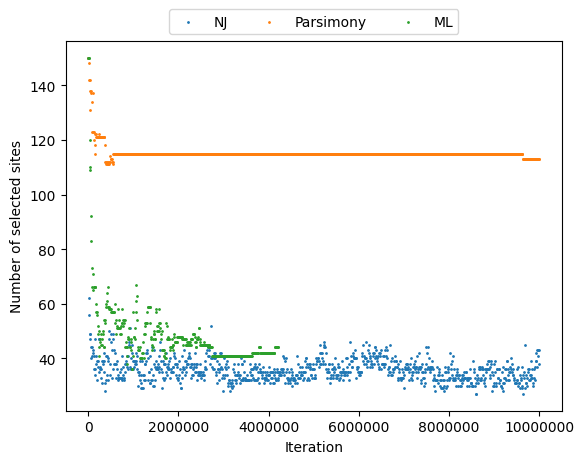

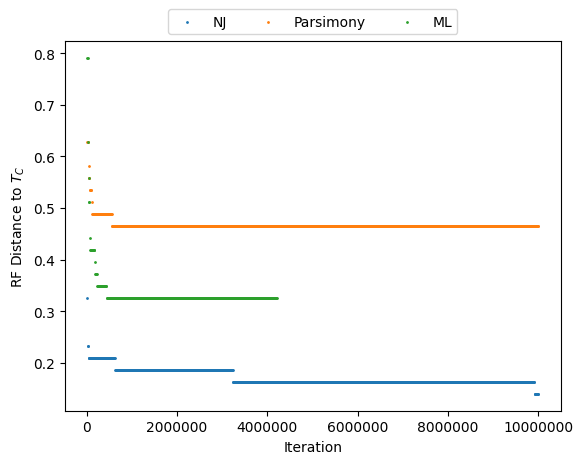

In [11]:
def plot_developement():
    indices_matrix, rfs, bit_matrix = get_results('nj')
    pars_indices_matrix, pars_rfs, pars_bit_matrix = get_results('pars')
    ml_indices_matrix, ml_rfs, ml_bit_matrix = get_results('ml')
    fig, ax = plt.subplots()
    x, y = scatter_dict(indices_matrix)
    plt.scatter(x, [len(indices) for indices in y], s=1, label = "NJ")
    x, y = scatter_dict(pars_indices_matrix)
    plt.scatter(x, [len(indices) for indices in y], s=1, label = "Parsimony")
    x, y = scatter_dict(ml_indices_matrix)
    plt.scatter(x, [len(indices) for indices in y], s=1, label = "ML")
    plt.xlabel('Iteration')
    plt.ylabel('Number of selected sites')
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)
    ax.ticklabel_format(style='plain')
    plt.show()

    fig, ax = plt.subplots()
    x, y = scatter_dict(rfs)
    plt.scatter(x, [rf/max_rf for rf in y], s=1, label = "NJ")
    x, y = scatter_dict(pars_rfs)
    plt.scatter(x, [rf/max_rf for rf in y], s=1, label = "Parsimony")
    x, y = scatter_dict(ml_rfs)
    plt.scatter(x, [rf/max_rf for rf in y], s=1, label = "ML")
    plt.xlabel('Iteration')
    plt.ylabel('RF Distance to $T_C$')
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)
    ax.ticklabel_format(style='plain')
    plt.show()
    
plot_developement()

In [10]:
_,_, nj_bit_matrix = get_results('nj')
_,_, pars_bit_matrix = get_results('pars')
_,_, ml_bit_matrix = get_results('ml')

#print_bit_matrix(nj_bit_matrix, 0, 1000)
#print_bit_matrix(pars_bit_matrix, 0, 1000)
#print_bit_matrix(ml_bit_matrix, 0, 1000)

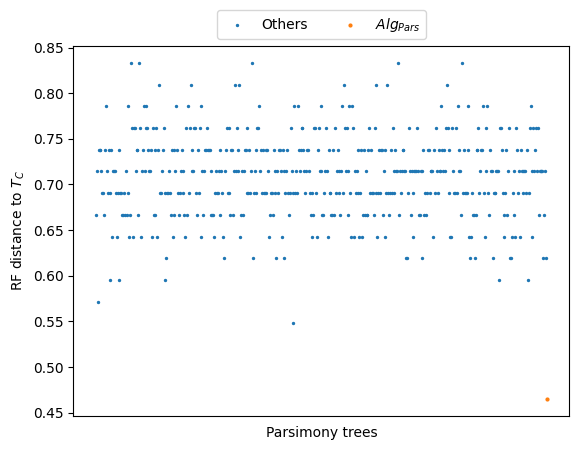

Fixed distance: 0.46511627906976744
Average distance: 0.7086190476190504
Standard deviation: 0.04538420015360816


In [13]:

def kinda_bootstrap(d):
    max_rf = 86
    pars_opt = 40 #manually
    cog_tree = Tree('data/trees/cognate_ie.tree')
    pars_trees = read_trees_from_ete(["../language_alignments/morpho_filtered_pars_final_pars/pars.raxml.startTree"])
    rfs = []
    for tree in pars_trees:
        rfs.append(rf_distance_ete(cog_tree, tree))
            
        
    fig, ax = plt.subplots()
    plt.scatter(range(len(rfs)), rfs, s =2, label = "Others")
    plt.scatter([len(rfs)], [pars_opt/max_rf], s =4, label = "$Alg_{Pars}$")
    plt.xlabel('Parsimony trees')
    plt.xticks([],[])
    plt.ylabel('RF distance to $T_C$')
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)        
    plt.show()
    
    print("Fixed distance: " + str(pars_opt/max_rf))
    print("Average distance: " + str(sum(rfs)/len(rfs)))
    print("Standard deviation: "+ str(np.std(rfs)))
    
kinda_bootstrap('output/project_pavlos/pars_results')

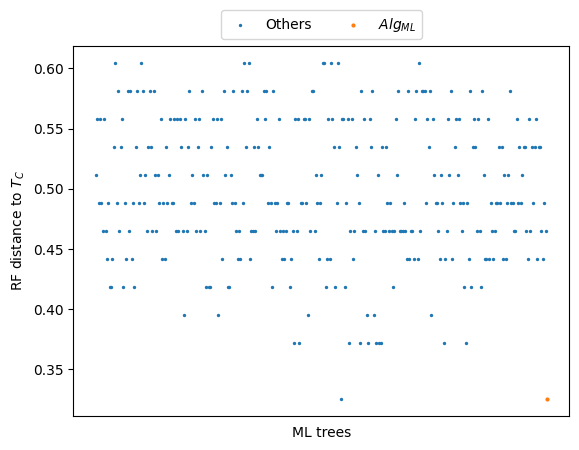

Fixed distance: 0.32558139534883723
Average distance: 0.4980147475893363
Standard deviation: 0.0570460087527565


In [12]:
def ml_stability():
    ml_opt = 28/86
    tree = Tree(tree_dir + "cognate_ie_compatible.tree")
    rfs = [rf_distance_ete(tree, t) for t in read_trees_from_ete(["pavlos_ml_all_ml.trees"])]
    fig, ax = plt.subplots()
    # for all samples with these indices, the tree is based on the same subalignment
    plt.scatter(range(len(rfs)), rfs, s =2, label = "Others")
    plt.scatter([len(rfs)], [ml_opt], s =4, label = "$Alg_{ML}$")
    plt.xlabel('ML trees')
    plt.xticks([],[])
    plt.ylabel('RF distance to $T_C$')
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)        
    plt.show()
    
    print("Fixed distance: " + str(ml_opt))
    print("Average distance: " + str(sum(rfs)/len(rfs)))
    print("Standard deviation: "+ str(np.std(rfs)))
    
ml_stability()

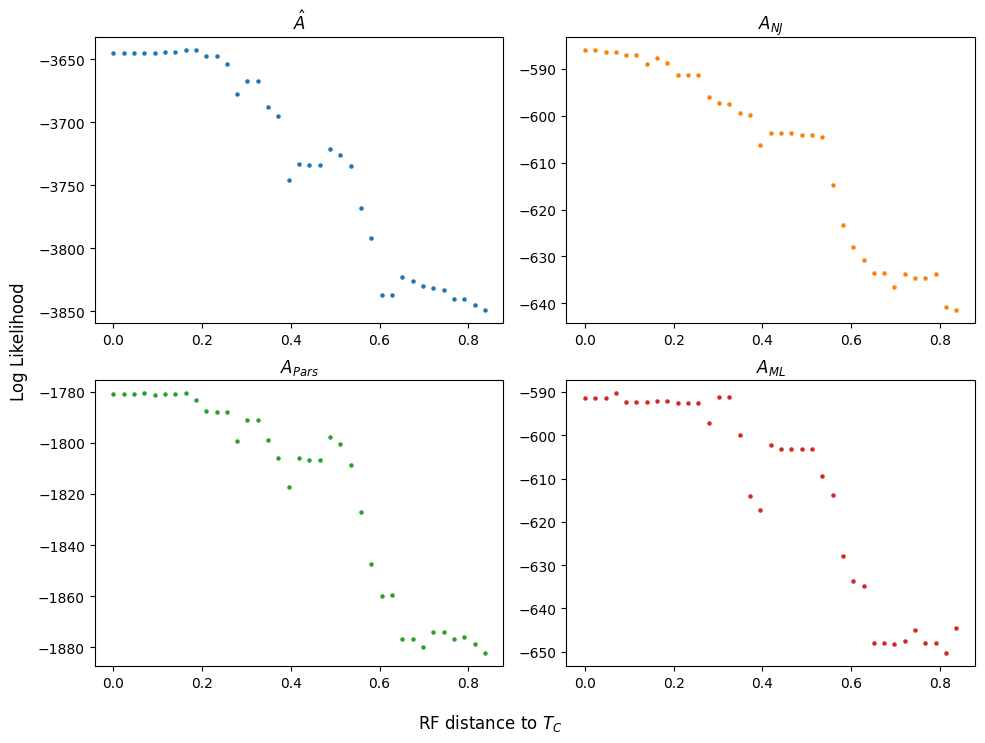

Rank Correlations
$\hat{A}$ & $A_{NJ}$ & 0.9570886676149832\\
$\hat{A}$ & $A_{Pars}$ & 0.9585111427216689\\
$\hat{A}$ & $A_{ML}$ & 0.9018492176386912\\
$A_{NJ}$ & $A_{Pars}$ & 0.9720246562351824\\
$A_{NJ}$ & $A_{ML}$ & 0.9279279279279279\\
$A_{Pars}$ & $A_{ML}$ & 0.9390706495969653\\
Correlation coefficients
$\hat{A}$ -0.9575334083841484 P-Value: 1.1991433973639087e-111
$A_{NJ}$ -0.9597845938624563 P-Value: 4.449314404206619e-99
$A_{Pars}$ -0.9273556982186546 P-Value: 1.2495892810245489e-111
$A_{ML}$ -0.9135193296210802 P-Value: 5.767550421782195e-94


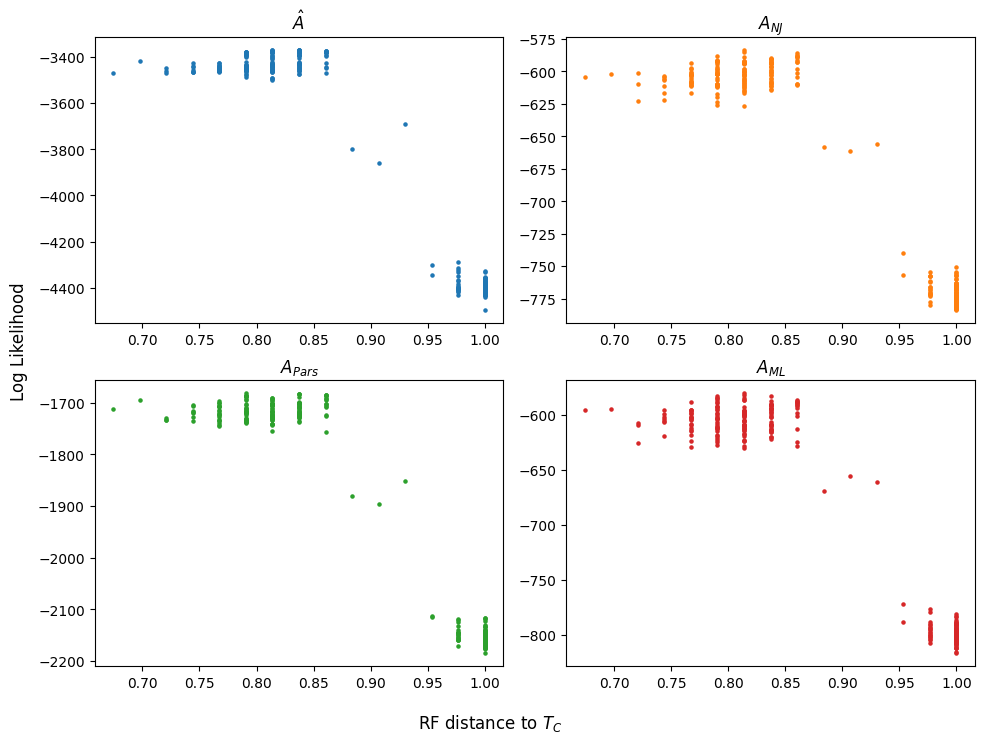

Rank Correlations
$\hat{A}$ & $A_{NJ}$ & 0.9507623744457514\\
$\hat{A}$ & $A_{Pars}$ & 0.947439004388743\\
$\hat{A}$ & $A_{ML}$ & 0.9150423321418876\\
$A_{NJ}$ & $A_{Pars}$ & 0.9255808297891593\\
$A_{NJ}$ & $A_{ML}$ & 0.9438887035109943\\
$A_{Pars}$ & $A_{ML}$ & 0.9408544758392904\\
Correlation coefficients
$\hat{A}$ -0.9472279438084154 P-Value: 0.0
$A_{NJ}$ -0.9440170524124488 P-Value: 0.0
$A_{Pars}$ -0.9503096038746638 P-Value: 0.0
$A_{ML}$ -0.9470900300364364 P-Value: 0.0


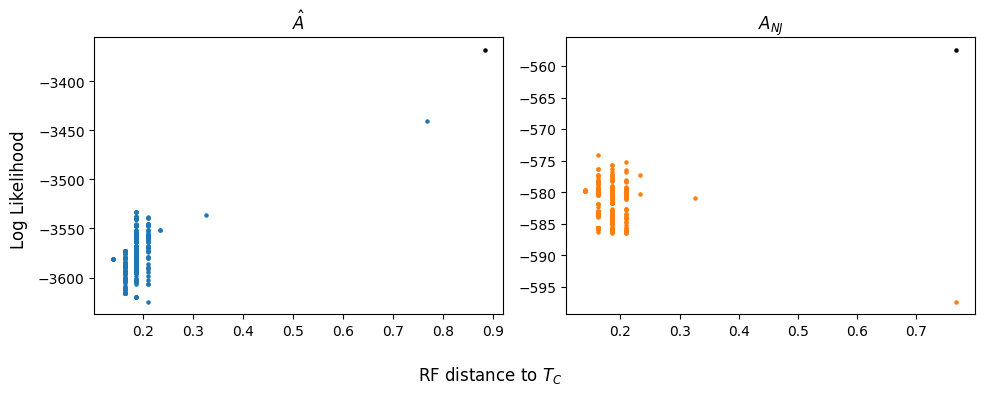

Rank Correlations
$\hat{A}$ & $A_{NJ}$ & 0.441190516599171\\
Correlation coefficients
$\hat{A}$ 0.531340943304012 P-Value: 0.0
$A_{NJ}$ -0.12734085262369266 P-Value: 0.0
RF Distance of best tree
$\hat{A}$ 0.8837209302325582
$A_{NJ}$ 0.7674418604651163


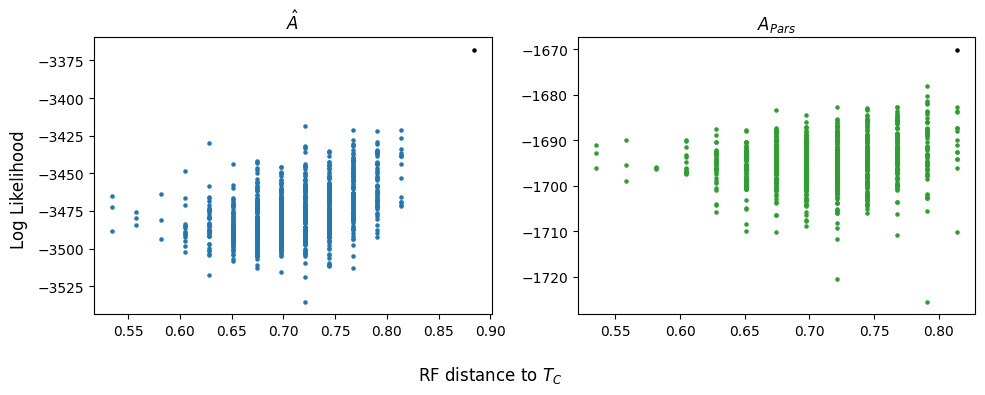

Rank Correlations
$\hat{A}$ & $A_{Pars}$ & 0.4901045900207576\\
Correlation coefficients
$\hat{A}$ 0.4374837392304286 P-Value: 0.0
$A_{Pars}$ 0.17114851023586677 P-Value: 0.0
RF Distance of best tree
$\hat{A}$ 0.8837209302325582
$A_{Pars}$ 0.813953488372093


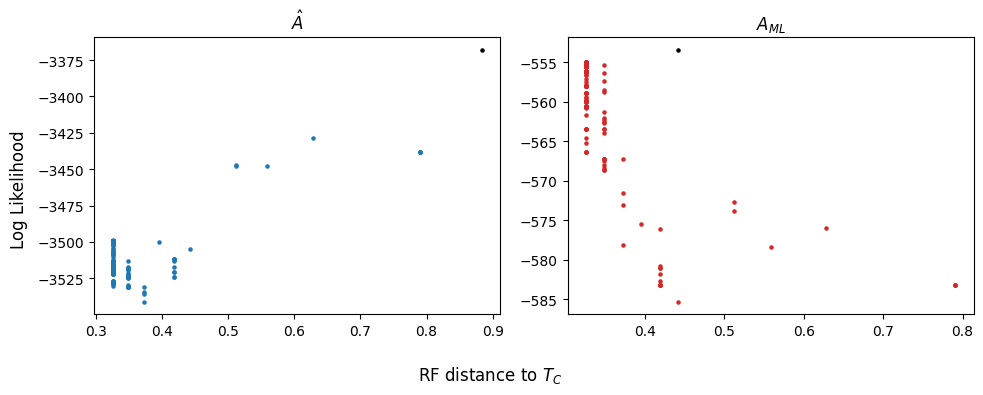

Rank Correlations
$\hat{A}$ & $A_{ML}$ & -0.049306104041647036\\
Correlation coefficients
$\hat{A}$ 0.5602371590228217 P-Value: 0.0
$A_{ML}$ -0.7178727478199132 P-Value: 0.0
RF Distance of best tree
$\hat{A}$ 0.8837209302325582
$A_{ML}$ 0.4418604651162791


In [29]:
from matplotlib.cm import get_cmap


def lh_and_cognate_distance(tree_set_names, names, show_reference = False):
    colors = get_cmap("tab10").colors
    trees = read_trees_from_ete(tree_set_names)
    cognate_tree = Tree(tree_dir + cognate_tree_name)
    rfs = rf_distances_ete(cognate_tree, trees)
    max_lhs = []
    rfs_ml_trees = []
    lh_matrix = []
    for (alignment_name, _) in names:
        lhs = []
        for tree_set_name in tree_set_names:
            lhs+= get_lhs_raw(tree_set_name, alignment_name, True)[0]
        cognate_lh = evaluate_lh_raxml(cognate_tree_name, alignment_name, optimize = False)
        lh_matrix.append(lhs)
        
        if(show_reference):
            best_tree = get_best_tree(alignment_name)
            max_lhs.append(calculate_site_lh_raxml_ete(best_tree, alignment_name, optimize=False)[0])
            rfs_ml_trees.append(rf_distance_ete(best_tree, cognate_tree))
 
    num_plots = len(names)
    num_rows = num_plots//2 + num_plots%2
    fig, arr = plt.subplots(num_rows, 2, figsize=(10, num_rows*4))
    ccs = []
    p_values =  []
    for i in range(num_plots):
        y = i%2
        if num_plots > 2:
            x = i//2
            arr[x,y].scatter(rfs, lh_matrix[i], s=5, color=colors[names[i][1]])
            if(show_reference):
                arr[x,y].scatter(rfs_ml_trees[i], max_lhs[i], s=5, color='black')
            arr[x,y].set_title(names_dict[names[i][0]])
        else:
            arr[y].scatter(rfs, lh_matrix[i], s=5, color=colors[names[i][1]])
            if(show_reference):
                arr[y].scatter(rfs_ml_trees[i], max_lhs[i], s=5, color='black')
            arr[y].set_title(names_dict[names[i][0]])
        ccs.append(pearson_cc(rfs, lh_matrix[i]))
        p_values.append(p_value(rfs, lh_matrix[i]))
    fig.supxlabel('RF distance to $T_C$')
    fig.supylabel('Log Likelihood')
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()
    print("Rank Correlations")
    for i in range(num_plots):
        for j in range(i+1, num_plots):
            res = stats.spearmanr(lh_matrix[i], lh_matrix[j])[0]
            print(names_dict[names[i][0]]+ " & " + names_dict[names[j][0]] + " & " + str(res) + "\\\\")
    print("Correlation coefficients")
    for i in range(num_plots):
        print(names_dict[names[i][0]]+ " " + str(ccs[i]) + " P-Value: " + str(p_values[i]))
        
    if show_reference:
        print("RF Distance of best tree")
        for i in range(num_plots):
            print(names_dict[names[i][0]]+ " " + str(rfs_ml_trees[i]))

lh_and_cognate_distance(["cognate_neighbors_90_sample.trees"],
                        [
                        ("morpho_filtered_indsToUse.phy", 0),
                        ("morpho_filtered_nj_final.phy",  1),
                        ("morpho_filtered_pars_final.phy", 2),
                        ("morpho_filtered_ml_final.phy", 3)
                        ], False)


lh_and_cognate_distance(["all.trees"],
                        [
                        ("morpho_filtered_indsToUse.phy", 0),
                        ("morpho_filtered_nj_final.phy",  1),
                        ("morpho_filtered_pars_final.phy", 2),
                        ("morpho_filtered_ml_final.phy", 3)
                        ], False)


lh_and_cognate_distance(["pavlos_nj.trees"],
                        [
                        ("morpho_filtered_indsToUse.phy", 0),
                        ("morpho_filtered_nj_final.phy",  1)
                        ], True)

lh_and_cognate_distance(["pavlos_pars.trees"],
                        [
                        ("morpho_filtered_indsToUse.phy", 0),
                        ("morpho_filtered_pars_final.phy",  2)
                        ], True)

lh_and_cognate_distance(["pavlos_ml.trees"],
                        [
                        ("morpho_filtered_indsToUse.phy", 0),
                        ("morpho_filtered_ml_final.phy",  3)
                        ], True)